#Initialize connection with Git and Drive

In [ ]:
from google.colab import drive
from os.path import join

!rm -r sample_data          # remove the automatically generated folder "sample_data"

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/project/'       # path to your project on Drive

GIT_USERNAME = "username" # replace with yours
GIT_TOKEN = "e12312fdsf23f23fsdfsdf23123df6457567dfsd"       # definitely replace with yours
GIT_REPOSITORY = "VDVAE-SR"                                  # Replace with the name of the repository                       

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)

GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"

!git clone "{GIT_PATH}"

!mv  Master-Thesis-WiP/* /content
!rm -r Master-Thesis-WiP


#This makes the py scripts to autoreload after changes
#this will make changes in py scripts to take effects imediatly instead of 
#having to restart the kernel
%load_ext autoreload
%autoreload 2

#Installing all the needed requirements, dependencies and libraries in the
# requirements.txt file in the git repo
!pip install -r requirements.txt

#To run Scripts just run: !python file.py

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

In [ ]:
!sh setup.sh
!rm -r ./apex
!rm -r setup.sh

#Environment Tests

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Set-up W&B

In [ ]:
%pip install wandb -q

# WandB – Import the wandb library
import wandb

# WandB – Login to your wandb account so you can log all your metrics
wandb.login()

# VDVAE SR

In [ ]:
from models.sr_vdvae_1 import *

ModelSR = SRVAE()

ModelSR.build_model(256, net_type = ffhq_256)
ModelSR.build_parcial_model(64, net_type = i64)
#for 64x64 model
#ModelSR.build_model(64, net_type = i64)
#ModelSR.build_parcial_model(16, net_type = NEW16)

In [ ]:
#loading pre-trained VDVAE model
model_path = "drive/MyDrive/imagenet64-iter-1600000-model.th"
model_path_ema = "drive/MyDrive/imagenet64-iter-1600000-model-ema.th"
ModelSR.load_saved_models(model_path, model_path_ema)
#ModelSR.load_saved_models_sr(model_path_sr, model_path_ema_sr)

In [ ]:
#loading pre-trained SR Model
#model_path = "drive/MyDrive/UNI stuff/Master Thesis/saved models/activations in prior-dec full open.h5"
model_path = "drive/MyDrive/UNI stuff/Master Thesis/saved models/VDVAE_SR_256_all_open.h5"

model_state_dict_save = {k:v for k,v in torch.load(model_path, map_location="cuda").items()}
model_state_dict = ModelSR.state_dict()
model_state_dict.update(model_state_dict_save)
ModelSR.load_state_dict(model_state_dict)

In [ ]:
from scripts.img_helper import *
from scripts.dataloader import *

path2 = "drive/MyDrive/Data/DIV2K/DIV2K_val/"

aux = SRDataLoader(path2,size = 64, batch_size=1)
dataloader2 = aux.get_dataloader()

for i_batch, sample_batched in enumerate(dataloader2):
  #print(sample_batched)
  break

In [ ]:
pic = sample_batched[0].to("cuda")
output = ModelSR.forward_sr_sample(pic, 1)

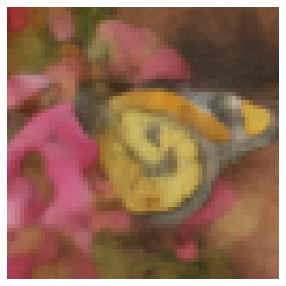

In [ ]:
imshow(output[0])

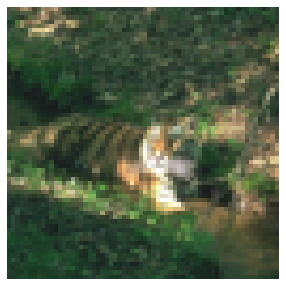

In [ ]:
imshow(sample_batched[0][0])

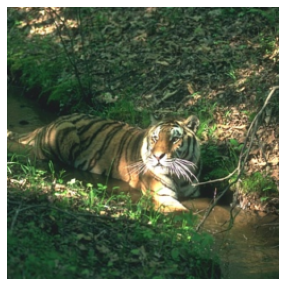

In [ ]:
imshow(sample_batched[1][0])

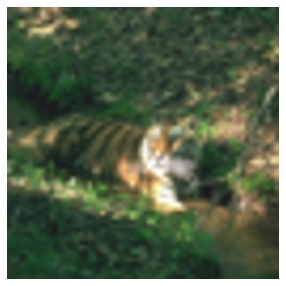

In [ ]:
to_pil_image = transforms.ToPILImage()
reupscaled = sample_batched[0][0]
reupscaled = to_pil_image(reupscaled)
reupscaled = reupscaled.resize((256, 256),resample=pil_image.BICUBIC)
imshow(reupscaled)

# VDVAE SR Training

In [ ]:
from scripts.dataloader import *
from scripts.img_helper import *
from scripts.training import *
from models.vae_test_model import *
import torch

trainer = Trainer()
training_step = training_step
test_step = test_step
path1 = "drive/MyDrive/Data/DIV2K/DIV2K_train/"
path2 = "drive/MyDrive/Data/DIV2K/DIV2K_val/"

loss_func = []
wandb.watch_called = False
trainer.epoch_start = 1

trainer.Main_start(batch_size = 4, test_batch_size = 4,
                 epochs = 1000, lr = 0.01, momentum = 0.5,
                 no_cuda = False, seed = 42, log_interval = 10,
                 project_name="full network", save_path = "drive/MyDrive/saved models/",
                 training_step= training_step, test_step= test_step, model = ModelSR, train_path=path1,
                 val_path=path2, scale = 4, reupscale = None,
                 single = None, size = 64, shuffle = True,
                 num_workers = 0, optimizer = torch.optim.AdamW,
                 optim_kwargs = None, resume = False,
                 resume_path = None, loss_func = loss_func, wandb = wandb, test_pic = pic)

#Metric Testing


In [ ]:
from scripts.testing import*
from scripts.img_helper import *
from scripts.dataloader import *
import random
path2 = "drive/MyDrive/Data/Test_Datasets/Set14/"
Tester = Tester()
psnr, ssim = Tester.main(test_step,"cuda",1,ModelSR,path2,size=256)
print("dataset:")
print("psnr: %0.2f"%psnr)
print("ssim: %0.4f"%ssim)

dataset:
psnr: 26.09
ssim: 0.7261


In [ ]:
def test_step(model, device, lr):
  lr = lr.to(device)
  output = model.forward_sr_sample(lr,1)
  return output